In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import os
import pandas as pd
import scipy.ndimage as ndi
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import seaborn as sns

# Load the T1 and T2 Flair image

In [41]:
img_path_T1 = '/content/drive/MyDrive/MAIA_Work/Semester_3/MISA/Lab 2/P2_data/1/T1.nii'
img_path_T2 = '/content/drive/MyDrive/MAIA_Work/Semester_3/MISA/Lab 2/P2_data/1/T2_FLAIR.nii'
img_data_T1 = nib.load(img_path_T1)
img_data_T2 = nib.load(img_path_T2)
img_T1 = img_data_T1.get_fdata()
img_T2 = img_data_T2.get_fdata()

# load the ground truth
gt_path = '/content/drive/MyDrive/MAIA_Work/Semester_3/MISA/Lab 2/P2_data/1/LabelsForTesting.nii'
gt_data = nib.load(gt_path)
gt = gt_data.get_fdata()

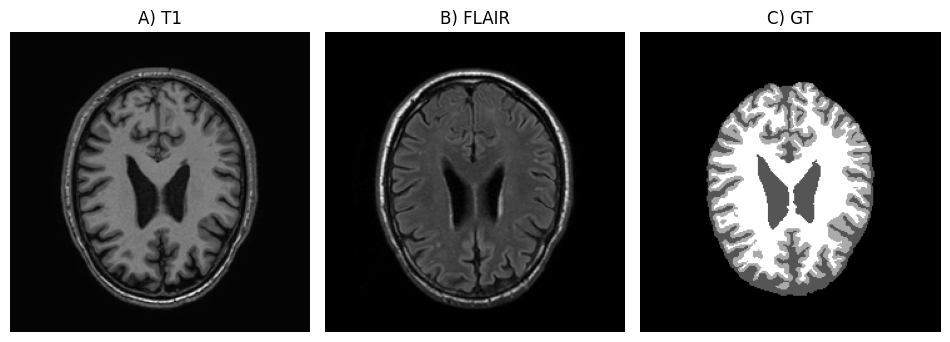

In [42]:
# Set up figure
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
slice_index = 26  # Choosing a different slice index for better view

# Display rotated T1 image
axes[0].imshow(np.rot90(img_T1[:, :, slice_index]), cmap='gray')
axes[0].axis('off')
axes[0].set_title('A) T1')

# Display rotated T2 FLAIR image
axes[1].imshow(np.rot90(img_T2[:, :, slice_index]), cmap='gray')
axes[1].axis('off')
axes[1].set_title('B) FLAIR')

# Display rotated Ground Truth image
axes[2].imshow(np.rot90(gt[:, :, slice_index]), cmap='gray')
axes[2].axis('off')
axes[2].set_title('C) GT')

# Adjust layout to keep images close
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Display the figure
plt.show()

In [43]:
y_T1 = img_T1[gt > 0]
y_T2 = img_T2[gt > 0]

print(type(y_T1))
print(y_T2.shape)

<class 'numpy.ndarray'>
(456532,)


# Initialize the parameters for EM algorithm

In [52]:
# Function to calculate the multivariate Gaussian probability density function
def gaussian_pdf(x, mu, cov):
    k = len(mu)  # Dimensionality of the data
    cov_inv = np.linalg.inv(cov)  # Inverse of the covariance matrix
    cov_det = np.linalg.det(cov)  # Determinant of the covariance matrix

    # Normalization factor (1 / sqrt((2 * pi)^k * det(cov)))
    norm_factor = 1 / np.sqrt((2 * np.pi) ** k * cov_det)

    # Compute the difference between x and mu for each data point
    diff = x - mu

    # Apply Gaussian PDF for each data point: (x - mu)^T * cov_inv * (x - mu)
    # This requires using a loop or vectorized broadcasting
    exp_term = np.einsum('ij,jk,ik->i', diff, cov_inv, diff)  # Efficient matrix multiplication for each sample

    # Return the Gaussian probability for each data point
    return norm_factor * np.exp(-0.5 * exp_term)

In [39]:
# # Function to calculate the Gaussian probability
# def gaussian_pdf(x, mu, cov):
#     return multivariate_normal.pdf(x, mean=mu, cov=cov)

In [59]:
# Expectation-Maximization (EM) algorithm
def em_algorithm(data, mu, sigma, pi, max_iter=100, tol=1e-6):

    n_samples, n_features = data.shape
    n_clusters = mu.shape[0]

    # Initialize the responsibilities matrix (E-step)
    responsibilities = np.zeros((n_samples, n_clusters))

    log_likelihoods = []

    for iter in range(max_iter):
      ### E-Step: Compute the responsibilities
      for i in range(n_clusters):
          responsibilities[:, i] = pi[i] * gaussian_pdf(data, mu[i], np.diag(sigma[i]**2))

      # Normalize responsibilities for each data point
      responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

      ### M-Step: Update parameters (mu, sigma, pi)
      N_k = responsibilities.sum(axis=0)  # Total responsibility assigned to each cluster

      # Update mu (means)
      for i in range(n_clusters):
          mu[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]

      # Update sigma (standard deviations)
      for i in range(n_clusters):
            diff = data - mu[i]
            sigma[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])

      # Update pi (mixing coefficients)
      pi = N_k / n_samples

      ### Compute the log likelihood for convergence check
      log_likelihood = np.sum(np.log(np.sum([pi[k] * gaussian_pdf(data, mu[k], np.diag(sigma[k]**2))
                                               for k in range(n_clusters)], axis=0)))
      log_likelihoods.append(log_likelihood)

      # Check for convergence
      if iter > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
          break

    return mu, sigma, pi, log_likelihoods, responsibilities

In [60]:
def dice_score(pred, true, label):
    """
    Calculate the Dice similarity coefficient for a specific label.

    Args:
        pred (ndarray): Predicted segmentation mask.
        true (ndarray): Ground truth mask.
        label (int): Label for which to calculate the Dice score.

    Returns:
        float: Dice similarity coefficient.
    """
    pred_mask = (pred == label)
    true_mask = (true == label)

    intersection = np.sum(pred_mask & true_mask)
    pred_sum = np.sum(pred_mask)
    true_sum = np.sum(true_mask)

    if pred_sum + true_sum == 0:
        return 1.0  # Avoid division by zero if both are empty
    return (2.0 * intersection) / (pred_sum + true_sum)


In [84]:
# # def process_em_for_folder(input_dir, output_dir):
# #     """
# #     Function to apply the Expectation-Maximization (EM) algorithm to MRI data (T1, T2_FLAIR) in a folder.
# #     It calculates the segmentation for GM, WM, CSF, and Background for both T1 and T2_FLAIR modalities.

# #     Args:
# #         input_dir (str): Path to the folder containing T1 and T2_FLAIR files.
# #         output_dir (str): Path to the folder where the resulting segmentation NIfTI file will be saved.

# #     Returns:
# #         dict: Dictionary containing results of EM algorithm and Dice scores for T1 and T2_FLAIR.
# #     """
# #     # File paths for T1, FLAIR, and ground truth (GT) modalities
# #     t1_file = os.path.join(input_dir, 'T1.nii')
# #     flair_file = os.path.join(input_dir, 'T2_FLAIR.nii')
# #     gt_file = os.path.join(input_dir, 'LabelsForTesting.nii')

# #     # Load the T1, FLAIR, and GT images
# #     t1_img = nib.load(t1_file)
# #     flair_img = nib.load(flair_file)
# #     gt_img = nib.load(gt_file)

# #     t1_data = t1_img.get_fdata()
# #     flair_data = flair_img.get_fdata()
# #     gt_data = gt_img.get_fdata()

# #     # Normalize the data to ensure consistent intensity range across folders
# #     t1_data = (t1_data - np.mean(t1_data)) / np.std(t1_data)
# #     flair_data = (flair_data - np.mean(flair_data)) / np.std(flair_data)

# #     # Use only the non-background pixels from the ground truth (gt_data > 0)
# #     y_T1 = t1_data[gt_data > 0]
# #     y_T2 = flair_data[gt_data > 0]

# #     # Combine the T1 and FLAIR data for EM clustering
# #     data = np.array([y_T1, y_T2]).T

# #     # KMeans initialization with multiple runs to ensure better clustering
# #     kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(data)
# #     mu = kmeans.cluster_centers_

# #     # Calculate sigma for each cluster
# #     labels = kmeans.labels_
# #     sigma = np.zeros_like(mu)
# #     for i in range(3):
# #         cluster_points = data[labels == i]
# #         sigma[i] = np.std(cluster_points, axis=0)

# #     # Initialize pi (mixing coefficients) to 1/3 for each cluster
# #     pi = np.ones(3) / 3

# #     # Run the EM algorithm
# #     mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(data, mu, sigma, pi)

# #     # Sort the clusters based on the intensity (mu) values
# #     sorted_indices = np.argsort(mu[:, 0])  # Sort based on the first dimension (T1)
# #     # Map the sorted indices to CSF, GM, and WM labels
# #     label_mapping = {sorted_indices[0]: 1, sorted_indices[1]: 2, sorted_indices[2]: 3}  # 1: CSF, 2: GM, 3: WM

# #     # Generate labels from responsibilities and map them (1-based)
# #     labels = np.argmax(responsibilities, axis=1)
# #     mapped_labels = np.vectorize(label_mapping.get)(labels)  # Apply the label mapping

# #     # Reshape the labels back to the original 3D shape
# #     label3d = np.zeros_like(gt_data)
# #     label3d[gt_data > 0] = mapped_labels

# #     # Convert to int32 to avoid type incompatibilities
# #     new_labels = label3d.astype(np.int32)

# #     # Save the segmentation mask as a NIfTI file
# #     segmentation_img = nib.Nifti1Image(new_labels, affine=t1_img.affine)
# #     output_file = os.path.join(output_dir, 'segmentation_mask.nii')
# #     nib.save(segmentation_img, output_file)
# #     print(f"Segmentation mask saved at {output_file}")

# #     # Calculate Dice scores for each label (1: CSF, 2: GM, 3: WM)
# #     dice_scores = {}
# #     for label in range(1, 4):  # Skip background (0)
# #         dice_scores[label] = dice_score(new_labels, gt_data, label)
# #         print(f"Dice score for label {label}: {dice_scores[label]}")

# #     # Return the EM results and Dice scores
# #     return {
# #         'mu': mu,
# #         'sigma': sigma,
# #         'dice_scores': dice_scores  # Store the dice scores for each label (CSF, GM, WM)
# #     }


# # def process_all_folders_with_em(parent_directory, output_parent_directory):
# #     """
# #     Function to loop through all subdirectories, apply the EM algorithm, and save the segmentation results.

# #     Args:
# #         parent_directory (str): Path to the directory containing subdirectories with the MRI files.
# #         output_parent_directory (str): Path to the directory where processed segmentation masks will be saved.

# #     Returns:
# #         dict: Dictionary containing EM results for all folders.
# #     """
# #     all_em_results = {}

# #     # Loop over all folders in the parent directory
# #     for folder_name in os.listdir(parent_directory):
# #         input_dir = os.path.join(parent_directory, folder_name)

# #         if os.path.isdir(input_dir):
# #             output_dir = os.path.join(output_parent_directory, folder_name)
# #             os.makedirs(output_dir, exist_ok=True)

# #             try:
# #                 # Process the folder and get EM results
# #                 em_results = process_em_for_folder(input_dir, output_dir)

# #                 # Store EM results for each folder
# #                 all_em_results[folder_name] = em_results
# #                 print(f"Processed folder: {folder_name} | EM Results: {em_results}")

# #             except Exception as e:
# #                 print(f"Error processing folder {folder_name}: {str(e)}")

# #     return all_em_results

# # Process a single folder with the EM algorithm
# def process_em_for_folder(input_dir, output_dir):
#     t1_file = os.path.join(input_dir, 'T1.nii')
#     flair_file = os.path.join(input_dir, 'T2_FLAIR.nii')
#     gt_file = os.path.join(input_dir, 'LabelsForTesting.nii')

#     t1_img = nib.load(t1_file)
#     flair_img = nib.load(flair_file)
#     gt_img = nib.load(gt_file)

#     t1_data = t1_img.get_fdata()
#     flair_data = flair_img.get_fdata()
#     gt_data = gt_img.get_fdata()

#     t1_data = (t1_data - np.mean(t1_data)) / np.std(t1_data)
#     flair_data = (flair_data - np.mean(flair_data)) / np.std(flair_data)

#     y_T1 = t1_data[gt_data > 0]
#     y_T2 = flair_data[gt_data > 0]
#     data = np.array([y_T1, y_T2]).T

#     kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(data)
#     mu = kmeans.cluster_centers_

#     labels = kmeans.labels_
#     sigma = np.zeros_like(mu)
#     for i in range(3):
#         cluster_points = data[labels == i]
#         sigma[i] = np.std(cluster_points, axis=0)

#     pi = np.ones(3) / 3
#     mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(data, mu, sigma, pi)

#     sorted_indices = np.argsort(mu[:, 0])
#     label_mapping = {sorted_indices[0]: 1, sorted_indices[1]: 2, sorted_indices[2]: 3}
#     labels = np.argmax(responsibilities, axis=1)
#     mapped_labels = np.vectorize(label_mapping.get)(labels)

#     label3d = np.zeros_like(gt_data)
#     label3d[gt_data > 0] = mapped_labels
#     new_labels = label3d.astype(np.int32)

#     segmentation_img = nib.Nifti1Image(new_labels, affine=t1_img.affine)
#     output_file = os.path.join(output_dir, 'segmentation_mask.nii')
#     nib.save(segmentation_img, output_file)
#     print(f"Segmentation mask saved at {output_file}")

#     dice_scores = {}
#     for label in range(1, 4):
#         dice_scores[label] = dice_score(new_labels, gt_data, label)
#         print(f"Dice score for label {label}: {dice_scores[label]}")

#     return {
#         'mu': mu,
#         'sigma': sigma,
#         'dice_scores': dice_scores,
#         'log_likelihoods': log_likelihoods
#     }

# # Process all folders and store Dice scores and log-likelihoods
# def process_all_folders_with_em(parent_directory, output_parent_directory):
#     dice_data = []
#     log_likelihood_data = []

#     for folder_name in os.listdir(parent_directory):
#         input_dir = os.path.join(parent_directory, folder_name)
#         if os.path.isdir(input_dir):
#             output_dir = os.path.join(output_parent_directory, folder_name)
#             os.makedirs(output_dir, exist_ok=True)

#             try:
#                 em_results = process_em_for_folder(input_dir, output_dir)

#                 for tissue, score in em_results['dice_scores'].items():
#                     tissue_name = 'CSF' if tissue == 1 else 'GM' if tissue == 2 else 'WM'
#                     dice_data.append({
#                         'Folder': folder_name,
#                         'Tissue': tissue_name,
#                         'DSC': score,
#                         'Algorithm': 'EM'
#                     })

#                 for i, log_value in enumerate(em_results['log_likelihoods']):
#                     log_likelihood_data.append({
#                         'Folder': folder_name,
#                         'Iteration': i,
#                         'LogLikelihood': log_value
#                     })

#             except Exception as e:
#                 print(f"Error processing folder {folder_name}: {str(e)}")

#     dice_df = pd.DataFrame(dice_data)
#     log_likelihood_df = pd.DataFrame(log_likelihood_data)

#     return dice_df, log_likelihood_df

# def create_dice_table(em_results):
#     """
#     Create a pandas DataFrame summarizing the Dice scores (mean and std) for CSF, GM, and WM for each folder.

#     Args:
#         em_results (dict): Dictionary containing the EM and Dice score results for each folder.

#     Returns:
#         pd.DataFrame: A DataFrame summarizing the mean and std Dice scores for CSF, GM, and WM.
#     """
#     rows = []

#     # Loop through each folder and get the dice scores
#     for folder, results in em_results.items():
#         # Extract the Dice scores for CSF, GM, and WM (labels 1, 2, 3)
#         csf_dice = results['dice_scores'][1]
#         gm_dice = results['dice_scores'][2]
#         wm_dice = results['dice_scores'][3]

#         # Compute the mean and std Dice scores
#         dice_values = np.array([csf_dice, gm_dice, wm_dice])
#         dice_mean = np.mean(dice_values)
#         dice_std = np.std(dice_values)

#         row = {
#             'Folder': folder,
#             'CSF Dice': csf_dice,
#             'GM Dice': gm_dice,
#             'WM Dice': wm_dice,
#             'Mean Dice': dice_mean,
#             'Std Dice': dice_std
#         }
#         rows.append(row)

#     # Create a DataFrame
#     df = pd.DataFrame(rows)

#     return df


In [78]:
# # Process a single folder with EM and KMeans algorithms
# def process_em_and_kmeans_for_folder(input_dir, output_dir):
#     # Load the images
#     t1_file = os.path.join(input_dir, 'T1.nii')
#     flair_file = os.path.join(input_dir, 'T2_FLAIR.nii')
#     gt_file = os.path.join(input_dir, 'LabelsForTesting.nii')

#     t1_img = nib.load(t1_file)
#     flair_img = nib.load(flair_file)
#     gt_img = nib.load(gt_file)

#     # Normalize data
#     t1_data = (t1_img.get_fdata() - np.mean(t1_img.get_fdata())) / np.std(t1_img.get_fdata())
#     flair_data = (flair_img.get_fdata() - np.mean(flair_img.get_fdata())) / np.std(flair_img.get_fdata())
#     gt_data = gt_img.get_fdata()

#     y_T1 = t1_data[gt_data > 0]
#     y_T2 = flair_data[gt_data > 0]
#     data = np.array([y_T1, y_T2]).T

#     # Run KMeans to initialize
#     kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(data)
#     mu_kmeans = kmeans.cluster_centers_
#     labels_kmeans = kmeans.labels_

#     # Calculate initial sigma based on KMeans clustering
#     sigma_kmeans = np.zeros_like(mu_kmeans)
#     for i in range(3):
#         cluster_points = data[labels_kmeans == i]
#         sigma_kmeans[i] = np.std(cluster_points, axis=0)

#     # EM processing
#     mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(data, mu_kmeans, sigma=sigma_kmeans, pi=np.ones(3) / 3)
#     sorted_indices = np.argsort(mu[:, 0])
#     label_mapping = {sorted_indices[0]: 1, sorted_indices[1]: 2, sorted_indices[2]: 3}

#     # Map EM labels to 3D format
#     labels_em = np.argmax(responsibilities, axis=1)
#     mapped_labels_em = np.vectorize(label_mapping.get)(labels_em)
#     label3d_em = np.zeros_like(gt_data)
#     label3d_em[gt_data > 0] = mapped_labels_em.astype(np.int32)

#     # Map KMeans labels to 3D format for Dice calculation
#     label3d_kmeans = np.zeros_like(gt_data)
#     label3d_kmeans[gt_data > 0] = np.vectorize(label_mapping.get)(labels_kmeans)

#     # Calculate Dice scores for EM and KMeans
#     dice_scores_em = {label: dice_score(label3d_em, gt_data, label) for label in range(1, 4)}
#     dice_scores_kmeans = {label: dice_score(label3d_kmeans, gt_data, label) for label in range(1, 4)}

#     # Store the segmentation mask
#     output_file = os.path.join(output_dir, 'segmentation_mask_em.nii')
#     nib.save(nib.Nifti1Image(label3d_em, affine=t1_img.affine), output_file)

#     return {
#         'dice_scores_em': dice_scores_em,
#         'dice_scores_kmeans': dice_scores_kmeans,
#         'log_likelihoods': log_likelihoods
#     }


# def process_all_folders_with_em_kmeans(parent_directory, output_parent_directory):
#     dice_data = []
#     log_likelihood_data = []

#     for folder_name in os.listdir(parent_directory):
#         input_dir = os.path.join(parent_directory, folder_name)
#         if os.path.isdir(input_dir):
#             output_dir = os.path.join(output_parent_directory, folder_name)
#             os.makedirs(output_dir, exist_ok=True)

#             try:
#                 results = process_em_and_kmeans_for_folder(input_dir, output_dir)
#                 for tissue, score in results['dice_scores_em'].items():
#                     dice_data.append({'Folder': folder_name, 'Tissue': tissue, 'DSC': score, 'Algorithm': 'EM'})
#                 for tissue, score in results['dice_scores_kmeans'].items():
#                     dice_data.append({'Folder': folder_name, 'Tissue': tissue, 'DSC': score, 'Algorithm': 'KMeans'})

#                 for i, log_value in enumerate(results['log_likelihoods']):
#                     log_likelihood_data.append({
#                         'Folder': folder_name,
#                         'Iteration': i,
#                         'LogLikelihood': log_value
#                     })

#             except Exception as e:
#                 print(f"Error processing folder {folder_name}: {str(e)}")

#     dice_df = pd.DataFrame(dice_data)
#     log_likelihood_df = pd.DataFrame(log_likelihood_data)
#     return dice_df, log_likelihood_df


# def plot_dice_scores_algorithm(dice_df):
#     """
#     Plot Dice scores for each tissue and algorithm with separate box plots.

#     Args:
#         dice_df (pd.DataFrame): DataFrame with columns 'Folder', 'Tissue', 'DSC', 'Algorithm'.
#     """
#     plt.figure(figsize=(8, 6))
#     sns.boxplot(data=dice_df, x='Tissue', y='DSC', hue='Algorithm', palette="Set2")
#     plt.title("Dice for Each Tissue and Algorithm")
#     plt.xlabel("Tissue")
#     plt.ylabel("Dice Score (DSC)")
#     plt.legend(title="Algorithm", loc="upper right")
#     plt.tight_layout()
#     plt.show()

# def plot_dice_scores_per_modality(dice_df):
#     """
#     Plot Dice scores for each tissue with different modalities.

#     Args:
#         dice_df (pd.DataFrame): DataFrame with columns 'Folder', 'Tissue', 'DSC', 'Modality'.
#     """
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(data=dice_df, x='Modality', y='DSC', hue='Tissue', palette="Set3")
#     plt.title("Dice Score for Each Tissue and Modality")
#     plt.xlabel("Modalities")
#     plt.ylabel("Dice Score (DSC)")
#     plt.legend(title="Tissue", loc="upper right")
#     plt.tight_layout()
#     plt.show()


# def plot_log_likelihood_subplots(log_likelihood_df):
#     unique_folders = log_likelihood_df['Folder'].unique()
#     fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
#     for i, folder in enumerate(unique_folders[:5]):  # Limit to 5 folders
#         subset = log_likelihood_df[log_likelihood_df['Folder'] == folder]
#         axs[i].plot(subset['Iteration'], subset['LogLikelihood'], label=f"{folder}")
#         axs[i].set_title(f"Log-Likelihood per Iteration for Folder {folder}")
#         axs[i].set_xlabel("Iteration")
#         axs[i].set_ylabel("Log-Likelihood")
#         axs[i].legend()
#     plt.tight_layout()
#     plt.show()

In [89]:
# Ensure em_algorithm and dice_score functions are defined
def process_em_and_kmeans_for_folder(input_dir, output_dir):
    # Load the images
    t1_file = os.path.join(input_dir, 'T1.nii')
    flair_file = os.path.join(input_dir, 'T2_FLAIR.nii')
    gt_file = os.path.join(input_dir, 'LabelsForTesting.nii')

    t1_img = nib.load(t1_file)
    flair_img = nib.load(flair_file)
    gt_img = nib.load(gt_file)

    # Normalize data
    t1_data = (t1_img.get_fdata() - np.mean(t1_img.get_fdata())) / np.std(t1_img.get_fdata())
    flair_data = (flair_img.get_fdata() - np.mean(flair_img.get_fdata())) / np.std(flair_img.get_fdata())
    gt_data = gt_img.get_fdata()

    results = {}

    # First case: Only T1
    y_T1 = t1_data[gt_data > 0]
    data_t1 = y_T1.reshape(-1, 1)

    # Run KMeans on T1 to initialize EM
    kmeans_t1 = KMeans(n_clusters=3, random_state=0, n_init=10).fit(data_t1)
    mu_kmeans_t1 = kmeans_t1.cluster_centers_
    labels_kmeans_t1 = kmeans_t1.labels_

    # Calculate initial sigma for T1-based clustering
    sigma_kmeans_t1 = np.array([np.std(data_t1[labels_kmeans_t1 == i]) for i in range(3)]).reshape(-1, 1)

    # EM on T1 data
    mu_em_t1, sigma_em_t1, pi_em_t1, log_likelihoods_t1, responsibilities_t1 = em_algorithm(
        data_t1, mu_kmeans_t1, sigma=sigma_kmeans_t1, pi=np.ones(3) / 3
    )
    labels_em_t1 = np.argmax(responsibilities_t1, axis=1)

    # Ensure consistent label mapping for T1
    sorted_indices_t1 = np.argsort(mu_em_t1[:, 0])
    label_mapping_t1 = {sorted_indices_t1[i]: i + 1 for i in range(3)}
    mapped_labels_em_t1 = np.vectorize(label_mapping_t1.get)(labels_em_t1)
    label3d_em_t1 = np.zeros_like(gt_data)
    label3d_em_t1[gt_data > 0] = mapped_labels_em_t1

    # Map KMeans labels for Dice calculation (T1 only)
    mapped_labels_kmeans_t1 = np.vectorize(label_mapping_t1.get)(labels_kmeans_t1)
    label3d_kmeans_t1 = np.zeros_like(gt_data)
    label3d_kmeans_t1[gt_data > 0] = mapped_labels_kmeans_t1

    # Calculate Dice scores for T1-based EM and KMeans
    dice_scores_em_t1 = {label: dice_score(label3d_em_t1, gt_data, label) for label in range(1, 4)}
    dice_scores_kmeans_t1 = {label: dice_score(label3d_kmeans_t1, gt_data, label) for label in range(1, 4)}

    # Store T1 results
    results['T1'] = {
        'dice_scores_em': dice_scores_em_t1,
        'dice_scores_kmeans': dice_scores_kmeans_t1,
        'log_likelihoods': log_likelihoods_t1
    }

    # Second case: T1 and T2 combined
    y_T2 = flair_data[gt_data > 0]
    data_t1_t2 = np.array([y_T1, y_T2]).T

    # Run KMeans on T1+T2 to initialize EM
    kmeans_t1_t2 = KMeans(n_clusters=3, random_state=0, n_init=10).fit(data_t1_t2)
    mu_kmeans_t1_t2 = kmeans_t1_t2.cluster_centers_
    labels_kmeans_t1_t2 = kmeans_t1_t2.labels_

    # Calculate initial sigma for T1+T2-based clustering
    sigma_kmeans_t1_t2 = np.array([np.std(data_t1_t2[labels_kmeans_t1_t2 == i], axis=0) for i in range(3)])

    # EM on T1+T2 data
    mu_em_t1_t2, sigma_em_t1_t2, pi_em_t1_t2, log_likelihoods_t1_t2, responsibilities_t1_t2 = em_algorithm(
        data_t1_t2, mu_kmeans_t1_t2, sigma=sigma_kmeans_t1_t2, pi=np.ones(3) / 3
    )
    labels_em_t1_t2 = np.argmax(responsibilities_t1_t2, axis=1)

    # Ensure consistent label mapping for T1+T2
    sorted_indices_t1_t2 = np.argsort(mu_em_t1_t2[:, 0])
    label_mapping_t1_t2 = {sorted_indices_t1_t2[i]: i + 1 for i in range(3)}
    mapped_labels_em_t1_t2 = np.vectorize(label_mapping_t1_t2.get)(labels_em_t1_t2)
    label3d_em_t1_t2 = np.zeros_like(gt_data)
    label3d_em_t1_t2[gt_data > 0] = mapped_labels_em_t1_t2

    # Map KMeans labels for Dice calculation (T1+T2)
    mapped_labels_kmeans_t1_t2 = np.vectorize(label_mapping_t1_t2.get)(labels_kmeans_t1_t2)
    label3d_kmeans_t1_t2 = np.zeros_like(gt_data)
    label3d_kmeans_t1_t2[gt_data > 0] = mapped_labels_kmeans_t1_t2

    # Calculate Dice scores for T1+T2-based EM and KMeans
    dice_scores_em_t1_t2 = {label: dice_score(label3d_em_t1_t2, gt_data, label) for label in range(1, 4)}
    dice_scores_kmeans_t1_t2 = {label: dice_score(label3d_kmeans_t1_t2, gt_data, label) for label in range(1, 4)}

    # Store T1+T2 results
    results['T1+T2'] = {
        'dice_scores_em': dice_scores_em_t1_t2,
        'dice_scores_kmeans': dice_scores_kmeans_t1_t2,
        'log_likelihoods': log_likelihoods_t1_t2
    }

    return results


def process_all_folders_with_em_kmeans(parent_directory, output_parent_directory):
    dice_data = []
    log_likelihood_data = []

    for folder_name in os.listdir(parent_directory):
        input_dir = os.path.join(parent_directory, folder_name)
        if os.path.isdir(input_dir):
            output_dir = os.path.join(output_parent_directory, folder_name)
            os.makedirs(output_dir, exist_ok=True)

            try:
                results = process_em_and_kmeans_for_folder(input_dir, output_dir)

                # Loop through modalities (T1 and T1+T2)
                for modality, result in results.items():
                    for tissue, score in result['dice_scores_em'].items():
                        dice_data.append({
                            'Folder': folder_name,
                            'Tissue': tissue,
                            'DSC': score,
                            'Algorithm': 'EM',
                            'Modality': modality
                        })
                    for tissue, score in result['dice_scores_kmeans'].items():
                        dice_data.append({
                            'Folder': folder_name,
                            'Tissue': tissue,
                            'DSC': score,
                            'Algorithm': 'KMeans',
                            'Modality': modality
                        })

                    for i, log_value in enumerate(result['log_likelihoods']):
                        log_likelihood_data.append({
                            'Folder': folder_name,
                            'Modality': modality,
                            'Iteration': i,
                            'LogLikelihood': log_value
                        })

            except Exception as e:
                print(f"Error processing folder {folder_name}: {str(e)}")

    dice_df = pd.DataFrame(dice_data)
    log_likelihood_df = pd.DataFrame(log_likelihood_data)
    return dice_df, log_likelihood_df


def plot_dice_scores_algorithm(dice_df):
    """
    Plot Dice scores for each tissue and algorithm with separate box plots.

    Args:
        dice_df (pd.DataFrame): DataFrame with columns 'Folder', 'Tissue', 'DSC', 'Algorithm', 'Modality'.
    """
    # Map tissue labels to GM, WM, CSF
    tissue_mapping = {1: "CSF", 2: "GM", 3: "WM"}
    dice_df['Tissue'] = dice_df['Tissue'].map(tissue_mapping)

    plt.figure(figsize=(8, 6))
    sns.boxplot(data=dice_df, x='Tissue', y='DSC', hue='Algorithm', palette="Set2")
    plt.title("Dice for Each Tissue and Algorithm")
    plt.xlabel("Tissue")
    plt.ylabel("Dice Score (DSC)")
    plt.legend(title="Algorithm", loc="upper right")
    plt.tight_layout()
    plt.show()


def plot_dice_scores_algorithm(dice_df):
    """
    Plot Dice scores for each tissue and algorithm with separate box plots.

    Args:
        dice_df (pd.DataFrame): DataFrame with columns 'Folder', 'Tissue', 'DSC', 'Algorithm', 'Modality'.
    """
    # Map tissue labels to GM, WM, CSF
    tissue_mapping = {1: "CSF", 2: "GM", 3: "WM"}
    dice_df = dice_df.copy()  # Make a copy to avoid modifying the original DataFrame
    dice_df['Tissue'] = dice_df['Tissue'].map(tissue_mapping)

    plt.figure(figsize=(8, 6))
    sns.boxplot(data=dice_df, x='Tissue', y='DSC', hue='Algorithm', palette="Set2")
    plt.title("Dice for Each Tissue and Algorithm")
    plt.xlabel("Tissue")
    plt.ylabel("Dice Score (DSC)")
    plt.legend(title="Algorithm", loc="upper right")
    plt.tight_layout()
    plt.show()


def plot_log_likelihood_subplots(log_likelihood_df):
    unique_folders = log_likelihood_df['Folder'].unique()
    fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
    for i, folder in enumerate(unique_folders[:5]):  # Limit to 5 folders
        subset = log_likelihood_df[log_likelihood_df['Folder'] == folder]
        axs[i].plot(subset['Iteration'], subset['LogLikelihood'], label=f"{folder}")
        axs[i].set_title(f"Log-Likelihood per Iteration for Folder {folder}")
        axs[i].set_xlabel("Iteration")
        axs[i].set_ylabel("Log-Likelihood")
        axs[i].legend()
    plt.tight_layout()
    plt.show()

In [91]:
# Parent directory where folders with T1 and T2_FLAIR are located
parent_directory = '/content/drive/MyDrive/MAIA_Work/Semester_3/MISA/Lab 2/P2_data'
output_parent_directory = '/content/drive/MyDrive/MAIA_Work/Semester_3/MISA/Lab 2/P2_data'

# Process all folders
dice_df, log_likelihood_df = process_all_folders_with_em_kmeans(parent_directory, output_parent_directory)

# Display the processed data (optional)
print(dice_df.head())
print(log_likelihood_df.head())

  Folder  Tissue       DSC Algorithm Modality
0      5       1  0.809050        EM       T1
1      5       2  0.848904        EM       T1
2      5       3  0.887694        EM       T1
3      5       1  0.856180    KMeans       T1
4      5       2  0.806150    KMeans       T1
  Folder Modality  Iteration  LogLikelihood
0      5       T1          0 -470299.904041
1      5       T1          1 -468316.842258
2      5       T1          2 -466665.042351
3      5       T1          3 -465205.662992
4      5       T1          4 -463900.149828


In [90]:
dice_df

,Folder,Tissue,DSC,Algorithm,Modality
0,5,NaN,0.809050,EM,T1
1,5,NaN,0.848904,EM,T1
2,5,NaN,0.887694,EM,T1
3,5,NaN,0.856180,KMeans,T1
4,5,NaN,0.806150,KMeans,T1
5,5,NaN,0.858304,KMeans,T1
6,5,NaN,0.885054,EM,T1+T2
7,5,NaN,0.865689,EM,T1+T2
8,5,NaN,0.893235,EM,T1+T2
9,5,NaN,0.870268,KMeans,T1+T2


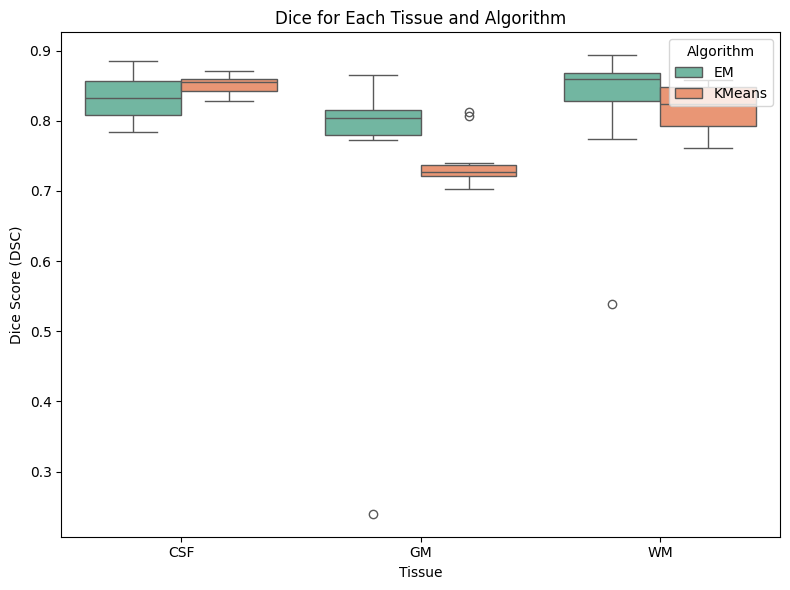

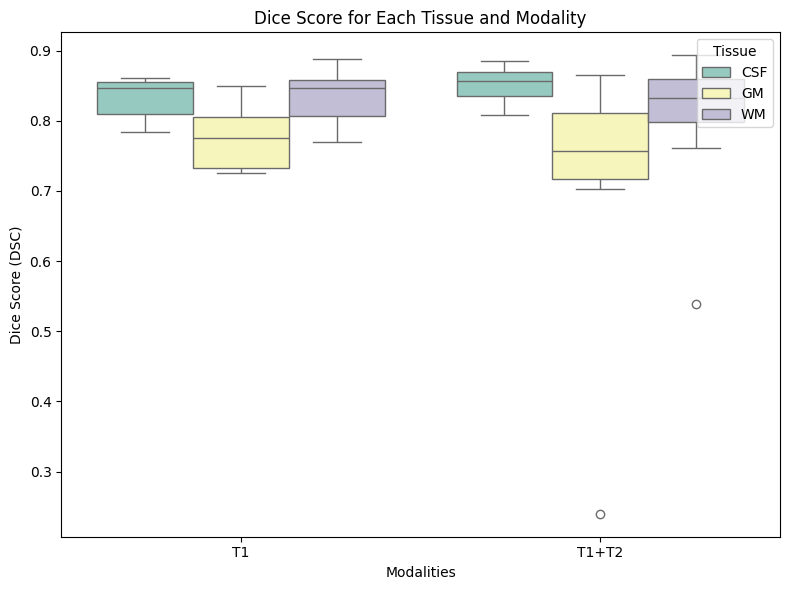

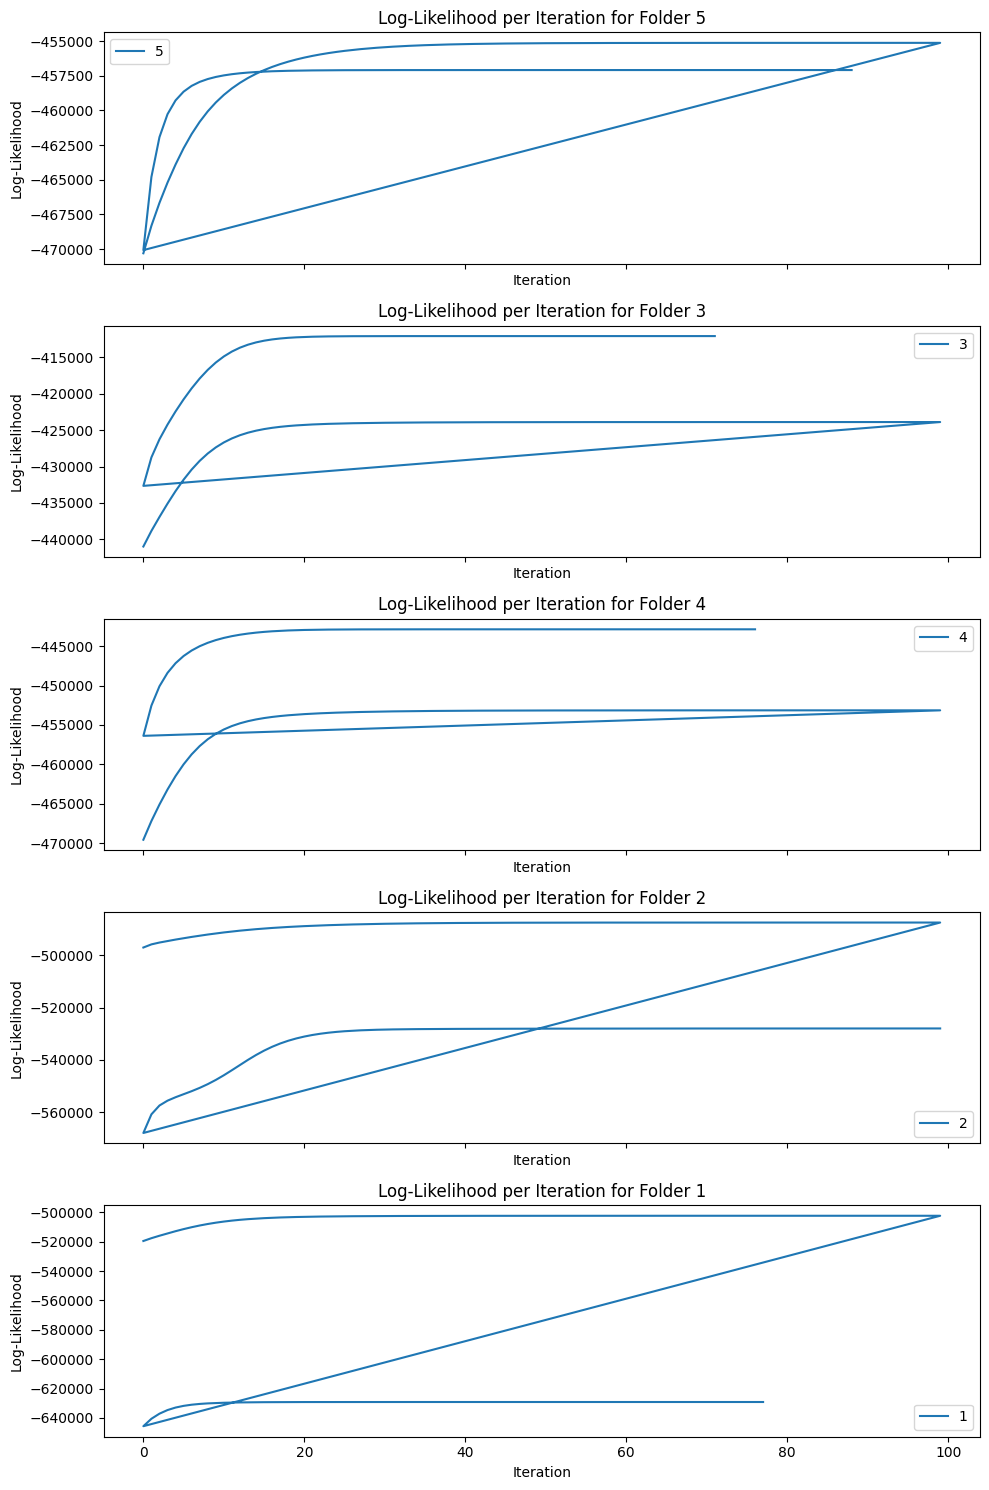

In [92]:
plot_dice_scores_algorithm(dice_df)
plot_dice_scores_per_modality(dice_df)
plot_log_likelihood_subplots(log_likelihood_df)

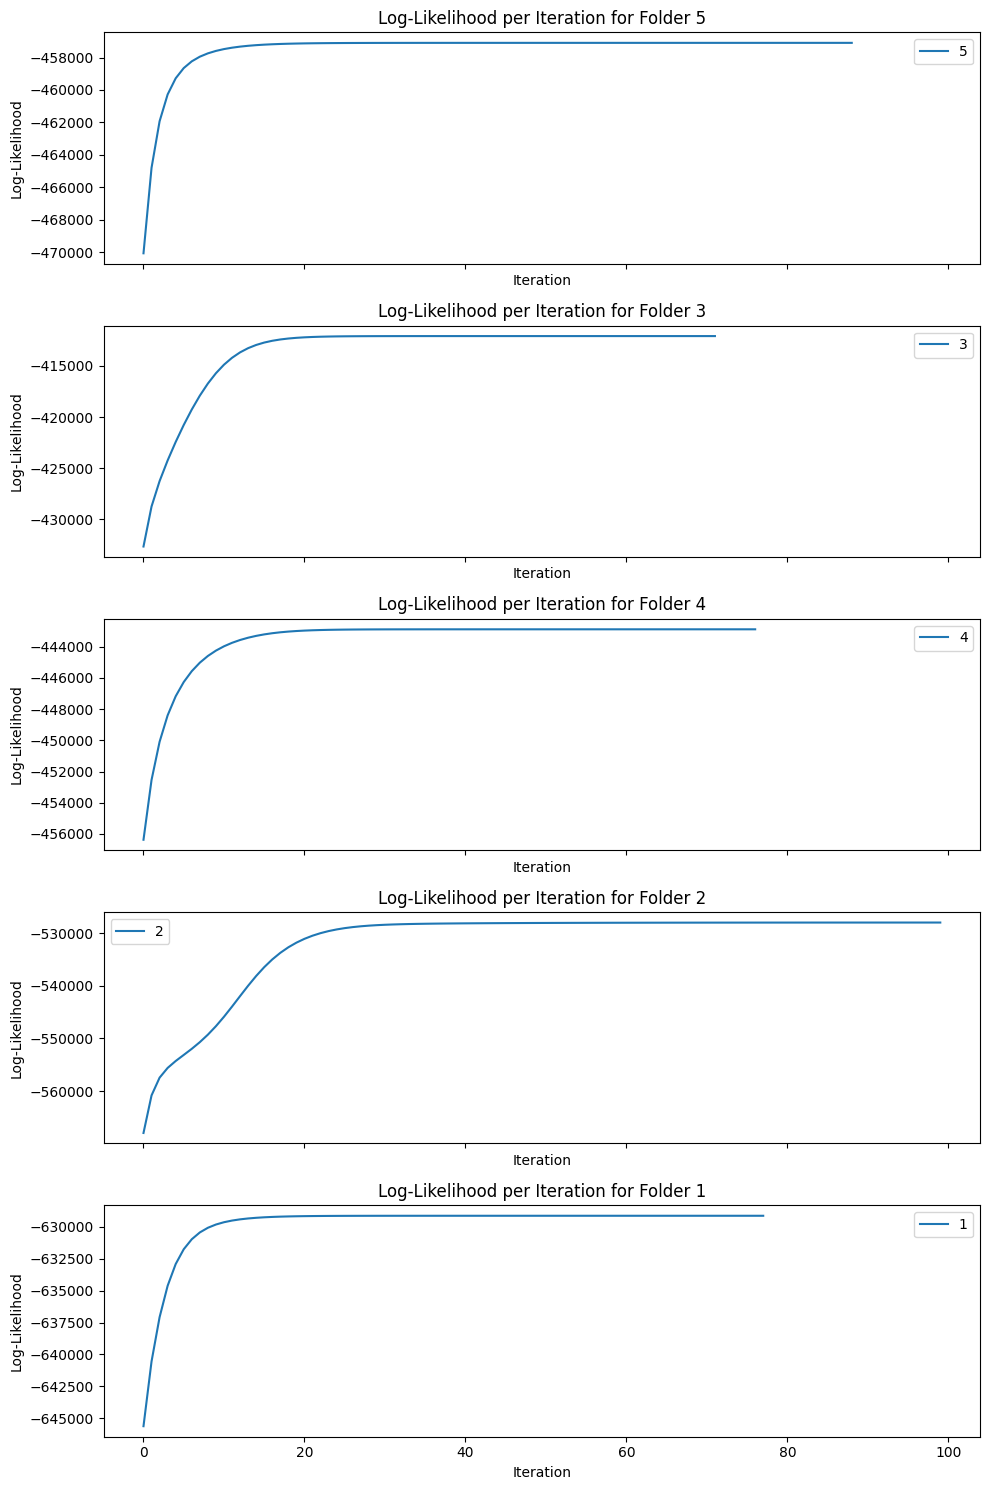

In [66]:
# Plot log-likelihood convergence for each folder (up to 5 folders)
plot_log_likelihood_subplots(log_likelihood_df)

## Testing EM using only T1 image for Folder 2 which has a low dice score

In [ ]:
img_path_T1_F2 = '/content/drive/MyDrive/MAIA Work/Semester 3/MISA/Lab 2/P2_data/2/T1.nii'

img_data_T1_F2 = nib.load(img_path_T1_F2)

img_T1_F2 = img_data_T1_F2.get_fdata()


# load the ground truth
gt_path_F2 = '/content/drive/MyDrive/MAIA Work/Semester 3/MISA/Lab 2/P2_data/2/LabelsForTesting.nii'
gt_data_F2 = nib.load(gt_path_F2)
gt_F2 = gt_data_F2.get_fdata()

In [ ]:
y_T1_F2 = img_T1_F2[gt_F2 > 0]

print(type(y_T1_F2))
print(y_T1_F2.shape)

<class 'numpy.ndarray'>
(502089,)


In [ ]:
# Stack them into a 2D array for clustering.
data_F2 = np.array([y_T1_F2]).T
print(data_F2.shape)

kmeans = KMeans(n_clusters=3, random_state=0).fit(data_F2)
mu_F2 = kmeans.cluster_centers_

labels = kmeans.labels_

sigma_F2 = []

# Compute the standard deviation for each cluster
for i in range(3):
    cluster_points = data_F2[labels == i]
    cluster_std = np.std(cluster_points, axis=0)
    sigma_F2.append(cluster_std)

sigma_F2 = np.array(sigma_F2)

# Set pi to 1/3 as we have three clusters
pi_F2 = [1/3, 1/3, 1/3]

print("mu (cluster centers):")
print(mu_F2)

print("sigma (cluster standard deviations):")
print(sigma_F2)

print("pi (mixing coefficient):")
print(pi_F2)

(502089, 1)
mu (cluster centers):
[[122.08826678]
 [ 43.93668832]
 [178.48172463]]
sigma (cluster standard deviations):
[[18.07892956]
 [21.7163549 ]
 [15.09850773]]
pi (mixing coefficient):
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


In [ ]:
mu_F2, sigma_F2, pi_F2, log_likelihoods_F2, responsibilities_F2 = em_algorithm(data_F2, mu_F2, sigma_F2, pi_F2)

In [ ]:
responsibilities_F2.shape

(502089, 3)

In [ ]:
# Sort the clusters based on the intensity (mu) values
sorted_indices_F2 = np.argsort(mu_F2[:, 0])  # Sort based on the first dimension (T1)
# Map the sorted indices to CSF, GM, and WM labels
label_mapping_F2 = {sorted_indices_F2[0]: 1, sorted_indices_F2[1]: 2, sorted_indices_F2[2]: 3}  # 1: CSF, 2: GM, 3: WM

# Generate labels from responsibilities and map them (1-based)
labels_F2 = np.argmax(responsibilities_F2, axis=1)
mapped_labels_F2 = np.vectorize(label_mapping_F2.get)(labels_F2)  # Apply the label mapping

# Reshape the labels back to the original 3D shape
label3d_F2 = np.zeros_like(gt_F2)
label3d_F2[gt_F2 > 0] = mapped_labels_F2

# Convert to int32 to avoid type incompatibilities
new_labels = label3d_F2.astype(np.int32)

In [ ]:
dice_scores = {}
for label in range(4):
    dice_scores[label] = dice_score(new_labels, gt_F2, label)
    print(f"T1 Dice score for label {label}: {dice_scores[label]}")

T1 Dice score for label 0: 1.0
T1 Dice score for label 1: 0.8525510691429117
T1 Dice score for label 2: 0.8024256824074835
T1 Dice score for label 3: 0.7742590766548311
